In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from simsimpy import *

In [78]:
# calculate bit error rate
fs = 4e6
T = 1/200
fc = 20e3
L0 = 50

offset = 0
phase_offset = 0*np.pi
error = 0
for i in range(100):

    # generate signal
    msk, t, data, _ = generate_msk(L0, 0.5, T, fc, fs, offset=offset, phase_offset=phase_offset)

    # add noise
    msk = msk + np.random.normal(0, 40, len(msk))

    # zeroes
    msk = add_zeros(msk, 0.0005, 0.0015, fs) 

    # downconvert
    s_down = msk*np.exp(-1j*2*np.pi*fc*t)

    # lowpass
    sos = signal.butter(5, 1/T, 'low', fs=fs, output='sos')
    temp = np.append(np.ones(int(fs*T))*np.mean(s_down[0:int(fs*T)]), s_down)
    s_down = signal.sosfiltfilt(sos, temp)[int(fs*T):]

    # decode
    decoded_data, _ = viterbi_decoder(s_down, int(T*fs))

    # measire error 
    error += np.sum(np.abs(decoded_data-data))


print(error)

826


In [70]:
fs = 4e6
T = 1/200
fc = 20e3
L0 = 50

offset = 0
phase_offset = 0*np.pi

# calculate the noise energi
noise = np.random.normal(0, 50, len(msk))

noise_down = noise*np.exp(-1j*2*np.pi*fc*t)
sos = signal.butter(5, 1/T, 'low', fs=fs, output='sos')
temp = np.append(np.ones(int(fs*T))*np.mean(noise_down[0:int(fs*T)]), noise_down)
s_filt = signal.sosfiltfilt(sos, temp)[int(fs*T):]

print(np.sum(np.abs(s_filt)**2))

# calculate the signal energi

msk, t, data, _ = generate_msk(L0, 0.5, T, fc, fs, offset=offset, phase_offset=phase_offset)
msk_down = msk*np.exp(-1j*2*np.pi*fc*t)
sos = signal.butter(5, 1/T, 'low', fs=fs, output='sos')
temp = np.append(np.ones(int(fs*T))*np.mean(msk_down[0:int(fs*T)]), msk_down)
msk_filt = signal.sosfiltfilt(sos, temp)[int(fs*T):]

print(np.sum(np.abs(msk_filt)**2))

# calculate the signal to noise ratio
print(10*np.log10(np.sum(np.abs(msk_filt)**2)/np.sum(np.abs(s_filt)**2)))

223374.57587249283
248615.39361786118
0.46494274614216463


In [10]:
def viterbi_metric(r, symbols, new_symbol, phase_start, where):
    # r : received signal
    # symbols : symbols to test
    # phase_start : phase of the signal at beginning of sequence

    phase = 0.5*np.pi*np.sum(symbols) + np.pi*new_symbol*np.linspace(0, 0.5, len(r), endpoint=False)+phase_start
    

    if where == 0:

        t = np.linspace(0, (len(data))*T, int(len(data)*T*fs), endpoint=False)
        t1 = int(where*fs*T)
        t2 = int((where+1)*fs*T)
        phase_plot = phase/np.pi % 2
        phase_plot[phase_plot< 1e-10] = np.nan
        plt.plot(t[t1:t2]/T, phase_plot)

    return np.sum(np.real(np.exp(-1j*phase)*r))

def viterbi_decoder(s, N):
    # s : received signal
    # T : symbol period
    # N : number of symbols

    # initial phase and symbols
    p0s = np.array([0,.5*np.pi,np.pi,1.5*np.pi]) 
    p0_max = 0
    for p in p0s:
        metric1 = viterbi_metric(s[:N], [], np.array([-1]), p, 0)
        metric2 = viterbi_metric(s[:N], [], np.array([1]), p, 0)
        if max(metric1, metric2) > p0_max:
            p0_max = max(metric1, metric2)
            phase_start = p

    print(phase_start/np.pi)
    path1 = np.array([-1])
    path2 = np.array([1])
    pm1 = viterbi_metric(s[:N], [], path1, phase_start, -1) # check if the phase is correct
    pm2 = viterbi_metric(s[:N], [], path2, phase_start, -1)
    
    for i in range(1,len(s)//N):
        pm1_0 = pm1 + viterbi_metric(s[i*N:(i+1)*N], path1,-1, phase_start, i)
        pm1_1 = pm1 + viterbi_metric(s[i*N:(i+1)*N], path1, 1, phase_start, i)
        pm2_0 = pm2 + viterbi_metric(s[i*N:(i+1)*N], path2,-1, phase_start, i)
        pm2_1 = pm2 + viterbi_metric(s[i*N:(i+1)*N], path2, 1, phase_start, i)
        
        print((path1+1)/2)
        print((path2+1)/2)
        
        if (pm1_0>pm2_0):
            path1_new = np.concatenate((path1,np.array([-1])))
        else:
            path1_new = np.concatenate((path2,np.array([-1])))

        if (pm1_1>pm2_1):
            path2_new = np.concatenate((path1,np.array([1])))
        else:
            path2_new = np.concatenate((path2,np.array([1])))

        
        pm1 = max(pm1_0, pm2_0)
        pm2 = max(pm1_1, pm2_1)

        (path1,path2) = (path1_new,path2_new)
        print((path1+1)/2)
        print((path2+1)/2)

    path1[path1 == -1] = 0
    path2[path2 == -1] = 0
    if (pm1 > pm2):
        return path1
    else:
        return path2

1.0
[0.]
[1.]
[0. 0.]
[0. 1.]
[0. 0.]
[0. 1.]
[0. 0. 0.]
[0. 0. 1.]
[0. 0. 0.]
[0. 0. 1.]
[0. 0. 1. 0.]
[0. 0. 1. 1.]
[0. 0. 1. 0.]
[0. 0. 1. 1.]
[0. 0. 1. 1. 0.]
[0. 0. 1. 1. 1.]
[0. 0. 1. 1. 0.]
[0. 0. 1. 1. 1.]
[0. 0. 1. 1. 0. 0.]
[0. 0. 1. 1. 0. 1.]
[0. 0. 1. 1. 0. 0.]
[0. 0. 1. 1. 0. 1.]
[0. 0. 1. 1. 0. 0. 0.]
[0. 0. 1. 1. 0. 0. 1.]
[0. 0. 1. 1. 0. 0. 0.]
[0. 0. 1. 1. 0. 0. 1.]
[0. 0. 1. 1. 0. 0. 0. 0.]
[0. 0. 1. 1. 0. 0. 0. 1.]


array([0, 0, 1, 1, 0, 0, 0, 1])

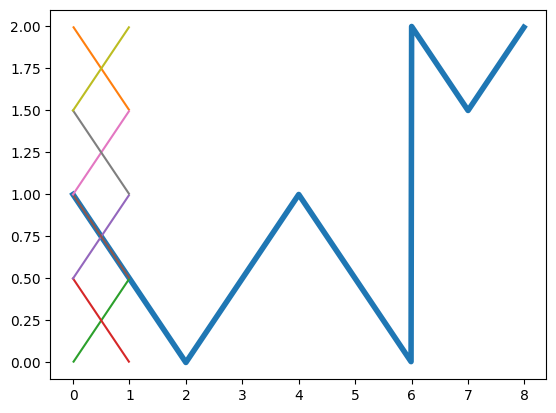

In [15]:
T = 0.1
fc = 1/T*1.25
#fc = 10
fs = 1000
data = np.array([0, 0, 1, 1, 0, 0, 0, 1])
s, t, phase = generate_msk_data(data, T, fc, fs, start_phase=1*np.pi)
plt.plot(t/T, phase/np.pi, linewidth=4)
#decode
decoded = viterbi_decoder(np.exp(1j*phase), 100)
decoded

array([1, 1, 1, 0, 1, 0, 1, 0, 0, 1])

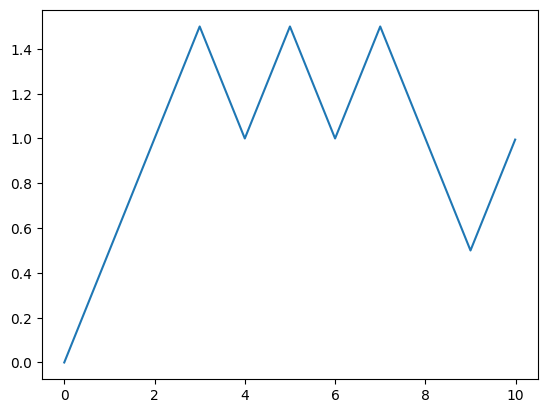

In [320]:
plt.plot(t/T, phase/np.pi)
data